<a href="https://colab.research.google.com/github/icanSeeo/i-can-see/blob/AI/CNN/cnn(resnet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [6]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 90320131.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31447480.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29899187.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4188770.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# ResNet 모델 정의
resnet = torchvision.models.resnet18(pretrained=False)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet.to(device)

# 손실 함수 및 최적화 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
# 모델 학습
num_epochs = 15

for epoch in range(num_epochs):
    running_loss = 0.0
    resnet.train()

    for i,(inputs , labels) in enumerate(trainloader):
        inputs , labels  	= inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs=resnet(inputs)
        loss=criterion(outputs , labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("학습 완료")

Epoch 1, Loss: 0.5737356553231475
Epoch 2, Loss: 0.09600799311218518
Epoch 3, Loss: 0.060960612843122916
Epoch 4, Loss: 0.04428319407300329
Epoch 5, Loss: 0.034382061975231686
Epoch 6, Loss: 0.027397516979349414
Epoch 7, Loss: 0.022638309533387097
Epoch 8, Loss: 0.01872256808782191
Epoch 9, Loss: 0.015111858433391502
Epoch 10, Loss: 0.012326019838688645
Epoch 11, Loss: 0.010136054248610107
Epoch 12, Loss: 0.0093459168320342
Epoch 13, Loss: 0.006975267382489065
Epoch 14, Loss: 0.005769786764562293
Epoch 15, Loss: 0.0050233353427593915
학습 완료


In [10]:

# 모델 평가
correct=0
total=0
resnet.eval()
with torch.no_grad():
    for data in testloader:
        images ,labels=data
        images ,labels		=images.to(device),labels.to(device)

outputs=resnet(images)
_,predicted=torch.max(outputs.data ,1 )
total+=labels.size(0)
correct+=(predicted==labels).sum().item()

print(f"테스트 데이터셋 정확도: {100 * correct / total}%")

테스트 데이터셋 정확도: 100.0%


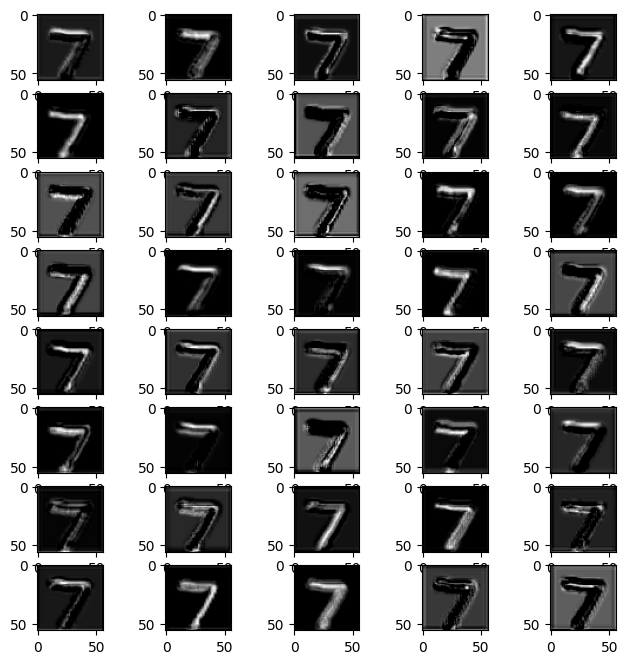

In [21]:
import matplotlib.pyplot as plt

# 테스트 데이터셋에서 한 배치의 데이터 가져오기

dataiter = enumerate(testloader)
_, (images, labels) = next(dataiter)

# 첫 번째 이미지 선택
image = images[0]

# 배치 차원 추가
image = image.unsqueeze(0)

# 이미지를 디바이스로 이동
if torch.cuda.is_available():
    image = image.to(device)

x = image

for name, layer in resnet.named_children():
    x = layer(x)
    if name == 'layer1':
        break

feature_maps = x.detach().cpu().numpy()

fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 8

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(feature_maps[0][i-1], cmap='gray')
plt.show()

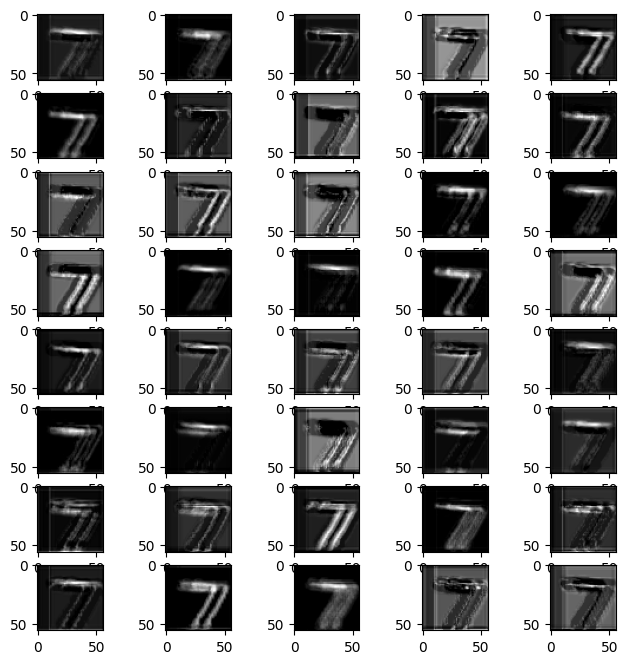

In [22]:
import cv2
import numpy as np


feature_maps = x.detach().cpu().numpy()

fig=plt.figure(figsize=(8 , 8))
columns = 5
rows = 8

# Affine transformation matrix for moving the image more to the right.
M = np.float32([[1, 0, 10], [0, 1, 0]])

for i in range(1, columns*rows +1):
    img = feature_maps[0][i-1]

    # Apply affine transformation.
    img_moved = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Create a "ghost" effect by combining the original and moved images.
    ghost_img = cv2.addWeighted(img.astype(np.float32), 0.5,
                                img_moved.astype(np.float32), 0.5,
                                0)

    fig.add_subplot(rows, columns, i)
    plt.imshow(ghost_img , cmap='gray')
plt.show()


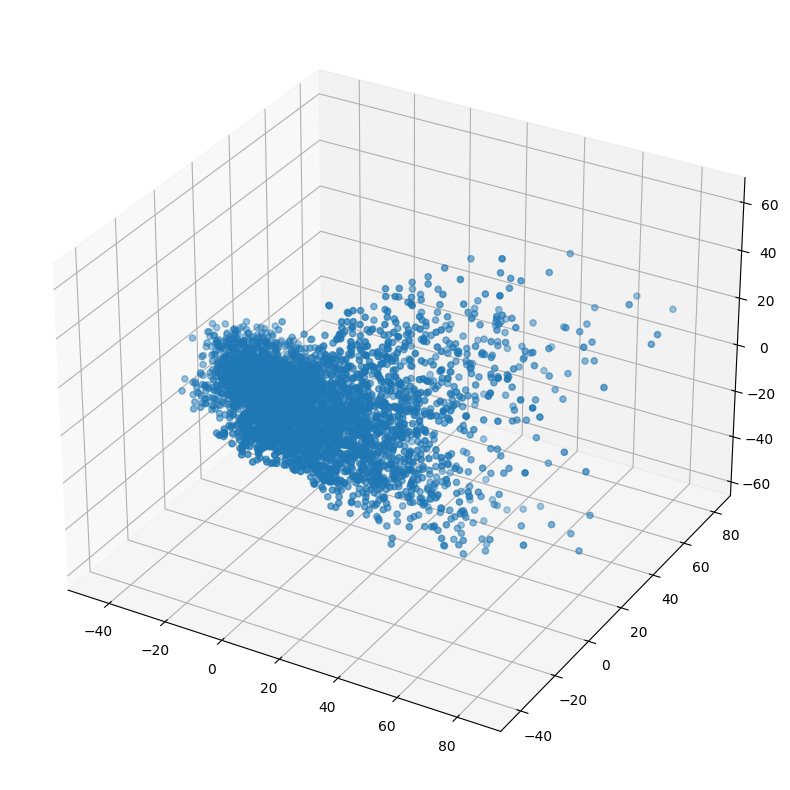

In [13]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


dataiter = enumerate(testloader)
_, (images, labels) = next(dataiter)


if torch.cuda.is_available():
    images = images.to(device)
# 모든 특징 맵 PCA
feature_maps_list = []
resnet.eval()
with torch.no_grad():
    for i, image in enumerate(images):
        image = image.unsqueeze(0)
        x = image
        for name, layer in resnet.named_children():
            x = layer(x)
            if name == 'layer1':
                feature_maps_list.append(x.squeeze().cpu().numpy())
                break

feature_maps_all_images = np.concatenate(feature_maps_list)


feature_maps_all_images_reshaped = feature_maps_all_images.reshape((feature_maps_all_images.shape[0], -1))

# PCA 객체
pca = PCA(n_components=3)

pca_result = pca.fit_transform(feature_maps_all_images_reshaped)

# 결과
fig=plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2])
plt.show()

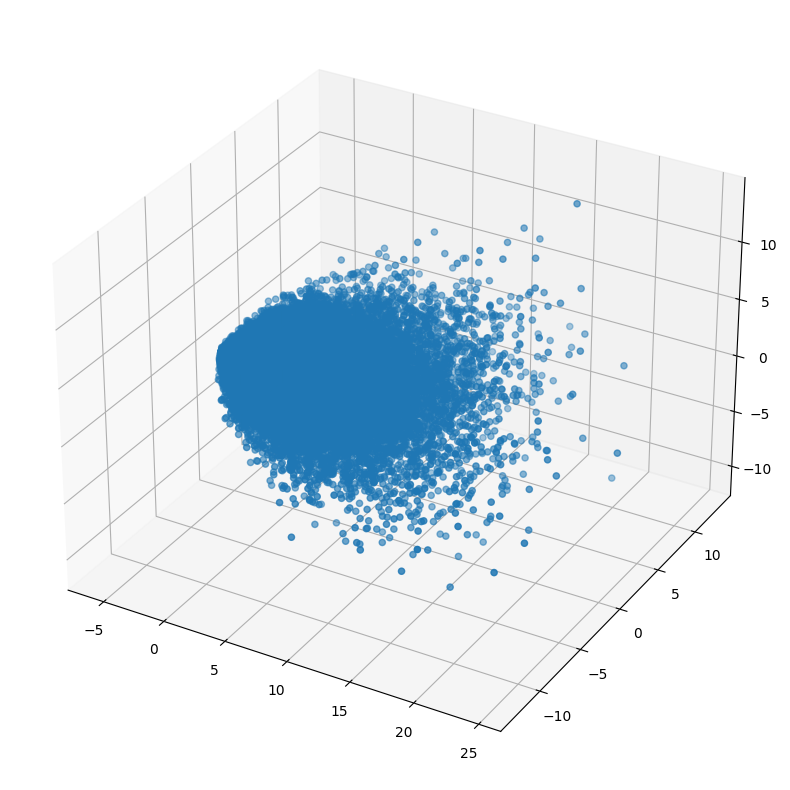

In [14]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

dataiter = enumerate(testloader)
_, (images, labels) = next(dataiter)

if torch.cuda.is_available():
    images = images.to(device)

feature_maps_list = []
resnet.eval()
with torch.no_grad():
    for i, image in enumerate(images):
        image = image.unsqueeze(0)
        x = image
        for name, layer in resnet.named_children():
            x = layer(x)
            if name == 'layer4':
                feature_maps_list.append(x.squeeze().cpu().numpy())
                break

feature_maps_all_images = np.concatenate(feature_maps_list)

feature_maps_all_images_reshaped = feature_maps_all_images.reshape((feature_maps_all_images.shape[0], -1))

pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_maps_all_images_reshaped)

fig=plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2])
plt.show()


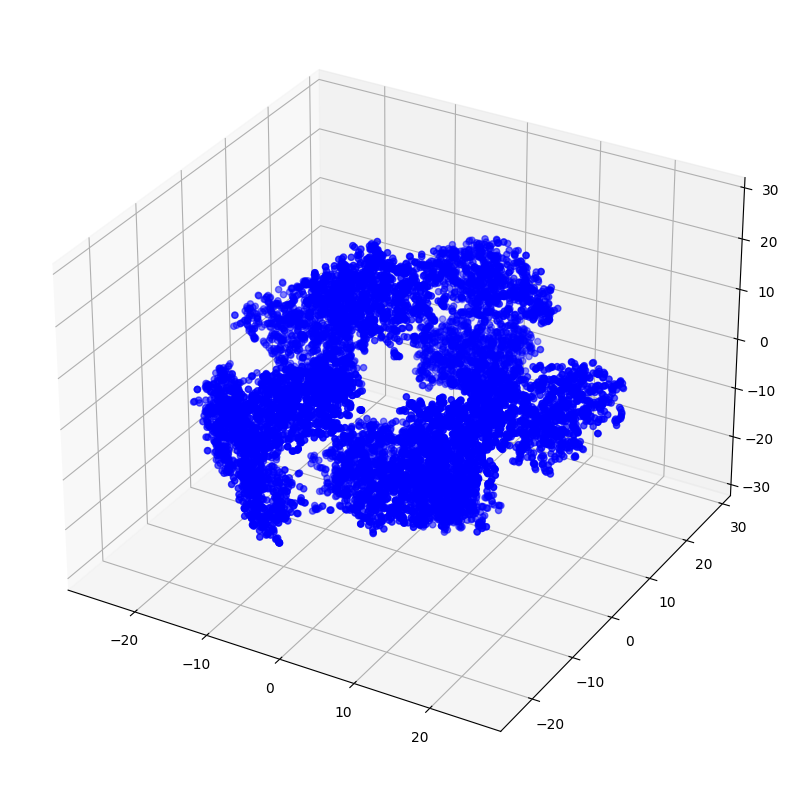

In [15]:
from sklearn.manifold import TSNE
# TSNE 4 layer
import numpy as np

feature_maps_last_layer = []
for i, (inputs , labels) in enumerate(testloader):
    inputs = inputs.to(device)

    x = inputs
    for name, layer in resnet.named_children():
        if name == 'layer4':
            x = layer(x)
            feature_maps_last_layer.append(x.detach().cpu().numpy())
            break
        else:
            x = layer(x)

feature_maps_last_layer_reshaped = np.concatenate(feature_maps_last_layer)
feature_map_shape = feature_maps_last_layer_reshaped.shape[1:]
feature_maps_last_layer_reshaped = feature_maps_last_layer_reshaped.reshape(-1, np.product(feature_map_shape))

# t-SNE 객체 생성
tsne = TSNE(n_components=3)

# 모든 특징 맵에 대해 t-SNE를 수행
tsne_result = tsne.fit_transform(feature_maps_last_layer_reshaped)

# 결과 시각화
fig=plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], color='b')
plt.show()

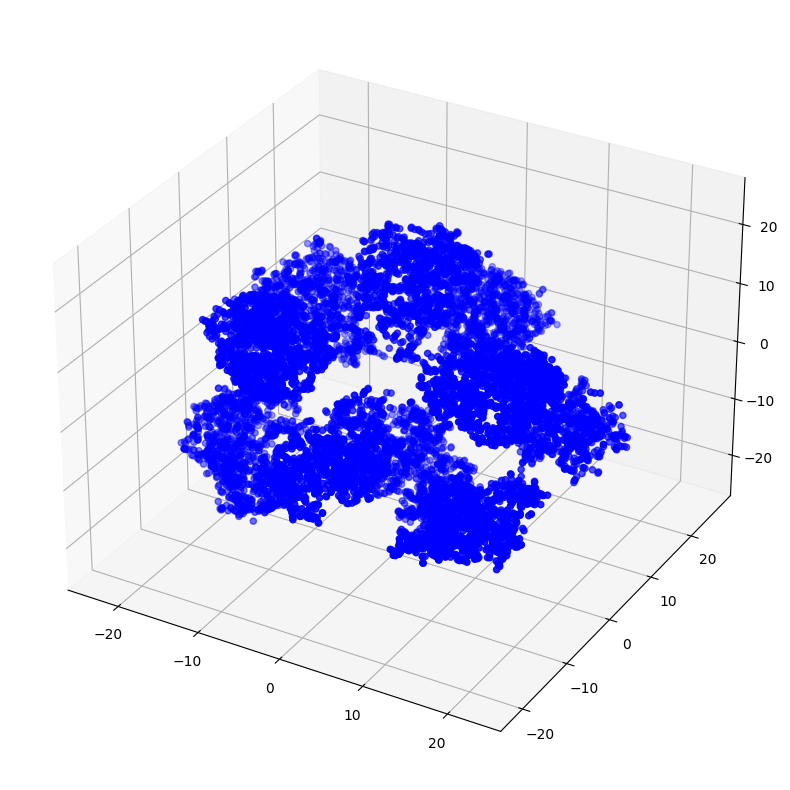

In [16]:
feature_maps_all_layers = []

# TSNE All layer
for i, (inputs , labels) in enumerate(testloader):
    inputs = inputs.to(device)

    x = inputs
    for name, layer in resnet.named_children():
        x = layer(x)
        if name == 'avgpool':
            feature_maps_all_layers.append(x.detach().cpu().numpy())
            break

# Flatten feature maps for dimension reduction methods
feature_map_shape = feature_maps_all_layers[0].shape[1:]
feature_maps_all_images_reshaped = np.concatenate(feature_maps_all_layers).reshape(-1,
                                                                                  np.product(feature_map_shape))

# t-SNE 객체 생성
tsne = TSNE(n_components=3)

# 모든 특징 맵에 대해 t-SNE를 수행
tsne_result_all_layers = tsne.fit_transform(feature_maps_all_images_reshaped)

# 결과 시각화
fig=plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result_all_layers[:,0], tsne_result_all_layers[:,1], tsne_result_all_layers[:,2], color='b')
plt.show()


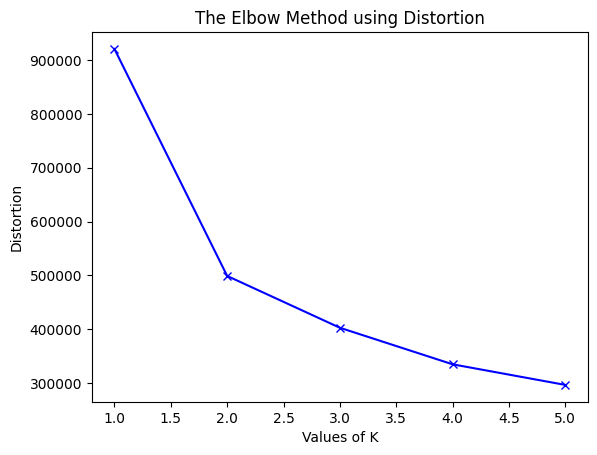

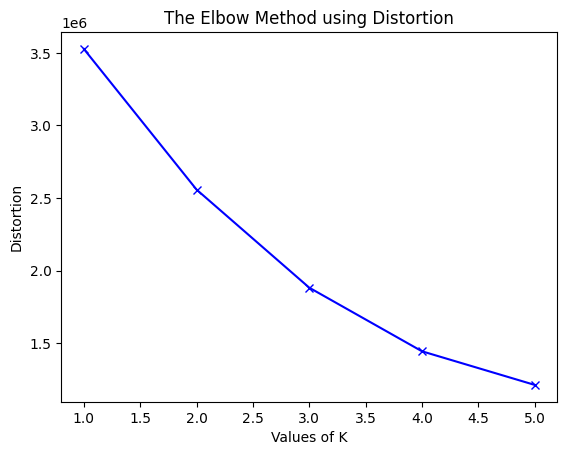

In [17]:
from sklearn.cluster import KMeans

def find_optimal_clusters(data):
    distortions = []
    K_to_try = range(1, 6)

    for i in K_to_try:
        model_pca_kmeans=KMeans(
            n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0
        )
        model_pca_kmeans.fit(data)
        distortions.append(model_pca_kmeans.inertia_)

    plt.plot(K_to_try,distortions,'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

find_optimal_clusters(pca_result)
find_optimal_clusters(tsne_result_all_layers)

In [18]:
def find_optimal_clusters(data):
    distortions = []
    K_to_try = range(1, 6)

    for i in K_to_try:
        model_pca_kmeans=KMeans(
            n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0
        )
        model_pca_kmeans.fit(data)
        distortions.append(model_pca_kmeans.inertia_)

    # Compute rate of change between successive distortion values
    diff = np.diff(distortions)

    # Find index of maximum change
    optimal_clusters = np.argmax(diff) + 2  # '+2' because index starts from '0' and we're looking for the next cluster after maximum change

    return optimal_clusters

optimal_pca_clusters = find_optimal_clusters(pca_result)
optimal_tsne_clusters = find_optimal_clusters(tsne_result_all_layers)

print(f"Optimal number of clusters for PCA: {optimal_pca_clusters}")
print(f"Optimal number of clusters for t-SNE: {optimal_tsne_clusters}")


Optimal number of clusters for PCA: 5
Optimal number of clusters for t-SNE: 5


Optimal number of clusters for PCA: 5
Optimal number of clusters for t-SNE: 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


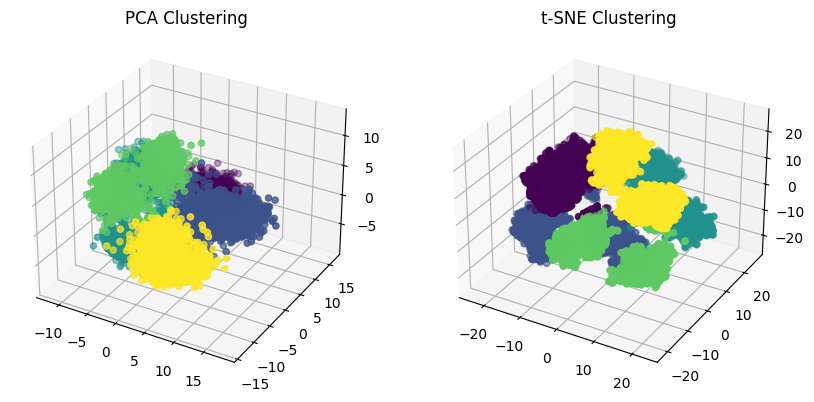

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def find_optimal_clusters(data):
    distortions = []
    K_to_try = range(1, 6)

    for i in K_to_try:
        model_pca_kmeans=KMeans(
            n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0
        )
        model_pca_kmeans.fit(data)
        distortions.append(model_pca_kmeans.inertia_)

    diff = np.diff(distortions)

    optimal_clusters = np.argmax(diff) + 2

    return optimal_clusters

feature_maps_all_layers = []

for i, (inputs , labels) in enumerate(testloader):
    inputs = inputs.to(device)

    x = inputs
    for name, layer in resnet.named_children():
        x = layer(x)
        if name == 'avgpool':
            feature_maps_all_layers.append(x.detach().cpu().numpy())
            break

feature_map_shape = feature_maps_all_layers[0].shape[1:]
feature_maps_all_images_reshaped = np.concatenate(feature_maps_all_layers).reshape(-1,
                                                                                  np.product(feature_map_shape))

pca_model=PCA(n_components=3)
pca_result=pca_model.fit_transform(feature_maps_all_images_reshaped)

tsne_model=TSNE(n_components=3)
tsne_result=tsne_model.fit_transform(feature_maps_all_images_reshaped)

optimal_pca_clusters=find_optimal_clusters(pca_result)
optimal_tsne_clusters=find_optimal_clusters(tsne_result)

print(f"Optimal number of clusters for PCA: {optimal_pca_clusters}")
print(f"Optimal number of clusters for t-SNE: {optimal_tsne_clusters}")

# Perform clustering using the optimal cluster numbers and visualize the results.
model_pca_kmeans = KMeans(n_clusters=optimal_pca_clusters).fit(pca_result)
model_tsne_kmeans = KMeans(n_clusters=optimal_tsne_clusters).fit(tsne_result)

fig=plt.figure(figsize=(10, 10))
ax1=plt.subplot(121, projection='3d')
ax2=plt.subplot(122, projection='3d')

ax1.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], c=model_pca_kmeans.labels_, cmap='viridis')
ax2.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], c=model_tsne_kmeans.labels_, cmap='viridis')

ax1.title.set_text('PCA Clustering')
ax2.title.set_text('t-SNE Clustering')

plt.show()


Optimal number of clusters for PCA: 5
Optimal number of clusters for t-SNE: 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


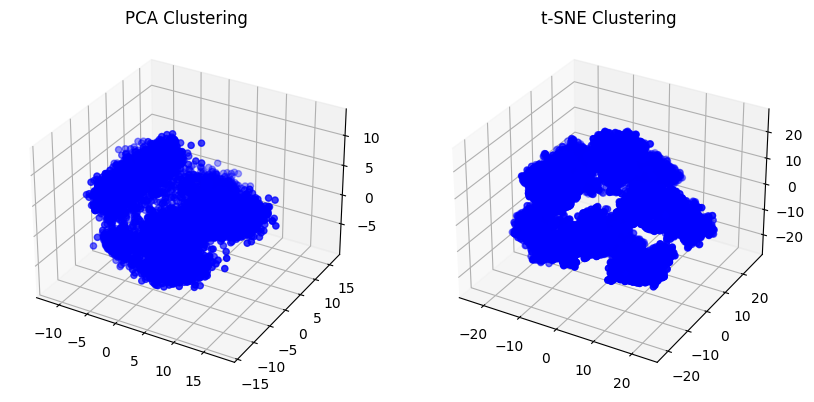

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def find_optimal_clusters(data):
    distortions = []
    K_to_try = range(1, 6)

    for i in K_to_try:
        model=KMeans(
            n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0
        )
        model.fit(data)
        distortions.append(model.inertia_)

    diff = np.diff(distortions)

    optimal_clusters = np.argmax(diff) + 2

    return optimal_clusters

feature_maps_all_layers = []

for i, (inputs , labels) in enumerate(testloader):
    inputs = inputs.to(device)

    x = inputs
    for name, layer in resnet.named_children():
        x = layer(x)
        if name == 'avgpool':
            feature_maps_all_layers.append(x.detach().cpu().numpy())
            break

feature_map_shape = feature_maps_all_layers[0].shape[1:]
feature_maps_all_images_reshaped = np.concatenate(feature_maps_all_layers).reshape(-1, np.product(feature_map_shape))

pca_model=PCA(n_components=3)
pca_result=pca_model.fit_transform(feature_maps_all_images_reshaped)

tsne_model=TSNE(n_components=3)
tsne_result=tsne_model.fit_transform(feature_maps_all_images_reshaped)

optimal_pca_clusters=find_optimal_clusters(pca_result)
optimal_tsne_clusters=find_optimal_clusters(tsne_result)

print(f"Optimal number of clusters for PCA: {optimal_pca_clusters}")
print(f"Optimal number of clusters for t-SNE: {optimal_tsne_clusters}")

# Perform clustering using the optimal cluster numbers and visualize the results.
model_pca_kmeans = KMeans(n_clusters=optimal_pca_clusters).fit(pca_result)
model_tsne_kmeans = KMeans(n_clusters=optimal_tsne_clusters).fit(tsne_result)


fig=plt.figure(figsize=(10, 10))
ax1=plt.subplot(121, projection='3d')
ax2=plt.subplot(122, projection='3d')

color='b'

ax1.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], color=color)
ax2.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], color=color)

ax1.title.set_text('PCA Clustering')
ax2.title.set_text('t-SNE Clustering')

plt.show()
